In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Pretrained Models**

**Using segmentation_models_pytorch**

In [ ]:
pip install segmentation-models-pytorch


In [ ]:
import segmentation_models_pytorch as smp

# Create model
model = smp.Unet(
    encoder_name="resnet34",        # backbone
    encoder_weights="imagenet",     # use pretrained weights
    in_channels=3,                  # input channels (RGB)
    classes=1,                      # output channels (1 for binary segmentation)
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
import torchvision.models.segmentation as models

model = models.deeplabv3_resnet50(pretrained=True)  # Pretrained on COCO


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:03<00:00, 45.2MB/s]


In [ ]:
pip install transformers


Before training, let’s make sure your images and masks align.

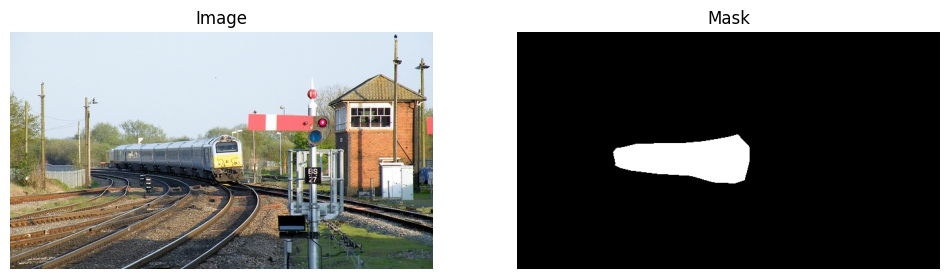

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random
import os

# pick a random training image
random_img = random.choice(os.listdir("data/images/train"))

img = cv2.imread(os.path.join("data/images/train", random_img))
mask_name = os.path.splitext(random_img)[0] + "_mask.png"
mask = cv2.imread(os.path.join("data/masks/train", mask_name), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.show()


In [ ]:
from PIL import Image
import numpy as np
import os
import torch
import cv2

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = [f for f in os.listdir(images_dir) if f.endswith(('.jpg','.png','.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Pick an image
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)

        # Convert image filename to mask filename (123.jpg → 123_mask.png)
        base_name = os.path.splitext(img_name)[0]       # "123"
        mask_name = base_name + "_mask.png"             # "123_mask.png"
        mask_path = os.path.join(self.masks_dir, mask_name)

        # ✅ Debug if mask is missing
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"❌ Mask not found for {img_name} → expected {mask_path}")


        # Load image and mask
        image = np.array(Image.open(img_path).convert("RGB"))
        mask  = np.array(Image.open(mask_path).convert("L"))

        # Binary mask
        mask = (mask > 127).astype(np.float32)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug["image"], aug["mask"]

        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2,0,1)  # (C,H,W)
        mask  = torch.tensor(mask, dtype=torch.float32)                  # (H,W)

        return image, mask

In [ ]:
dataset = SegmentationDataset("data/images/train", "data/masks/train")
print("Number of samples:", len(dataset))

img, mask = dataset[0]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)


Number of samples: 125
Image shape: torch.Size([3, 612, 612])
Mask shape: torch.Size([612, 612])


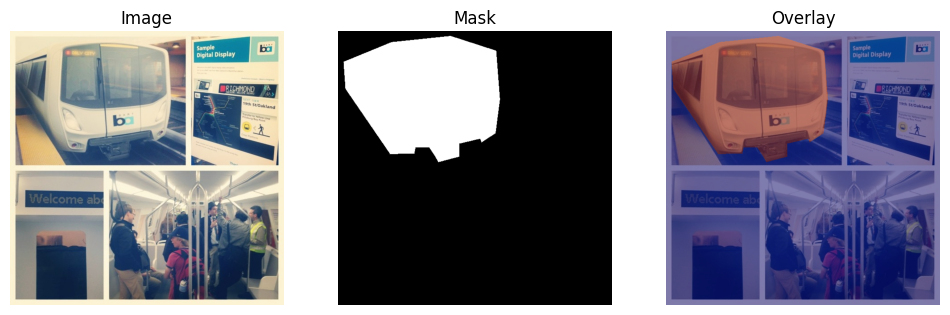

In [ ]:
import matplotlib.pyplot as plt

# Take one sample
img, mask = dataset[0]   # (C,H,W) and (H,W)

# Convert to numpy for plotting
img_np = img.permute(1,2,0).numpy()   # (H,W,C)
mask_np = mask.numpy()                # (H,W)

plt.figure(figsize=(12,6))

# Original Image
plt.subplot(1,3,1)
plt.imshow(img_np.astype("uint8"))
plt.title("Image")
plt.axis("off")

# Mask
plt.subplot(1,3,2)
plt.imshow(mask_np, cmap="gray")
plt.title("Mask")
plt.axis("off")

# Overlay
plt.subplot(1,3,3)
plt.imshow(img_np.astype("uint8"))
plt.imshow(mask_np, cmap="jet", alpha=0.5)  # semi-transparent mask
plt.title("Overlay")
plt.axis("off")

plt.show()


Total pairs found: 157
Loaded X_train: (157, 256, 256, 3) y_train: (157, 256, 256, 1)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 47,128,385 (179.78 MB)

 Trainable params: 23,540,673 (89.80 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 512s 23s/step - loss: 1.4047 - mean_io_u: 0.3720 - pixel_accuracy: 0.5830
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 451s 23s/step - loss: 0.7120 - mean_io_u: 0.3741 - pixel_accuracy: 0.8677
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 556s 25s/step - loss: 0.4836 - mean_io_u: 0.3790 - pixel_accuracy: 0.9094
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 440s 22s/step - loss: 0.3535 - mean_io_u: 0.3778 - pixel_accuracy: 0.9365
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 442s 22s/step - loss: 0.3277 - mean_io_u: 0.3759 - pixel_accuracy: 0.9374
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 441s 22s/step - loss: 0.2508 - mean_io_u: 0.3838 - pixel_accuracy: 0.9556
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 445s 22s/step - loss: 0.1664 - mean_io_u: 0.3871 - pixel_accuracy: 0.9687
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 444s 22s/step - loss: 0.1513 - mean_io_u: 0.3737 - pixel_accuracy: 0.9713
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 500s 22s/step - loss: 0.1568 - mean_io_u: 0.3842 - pixel_accuracy:

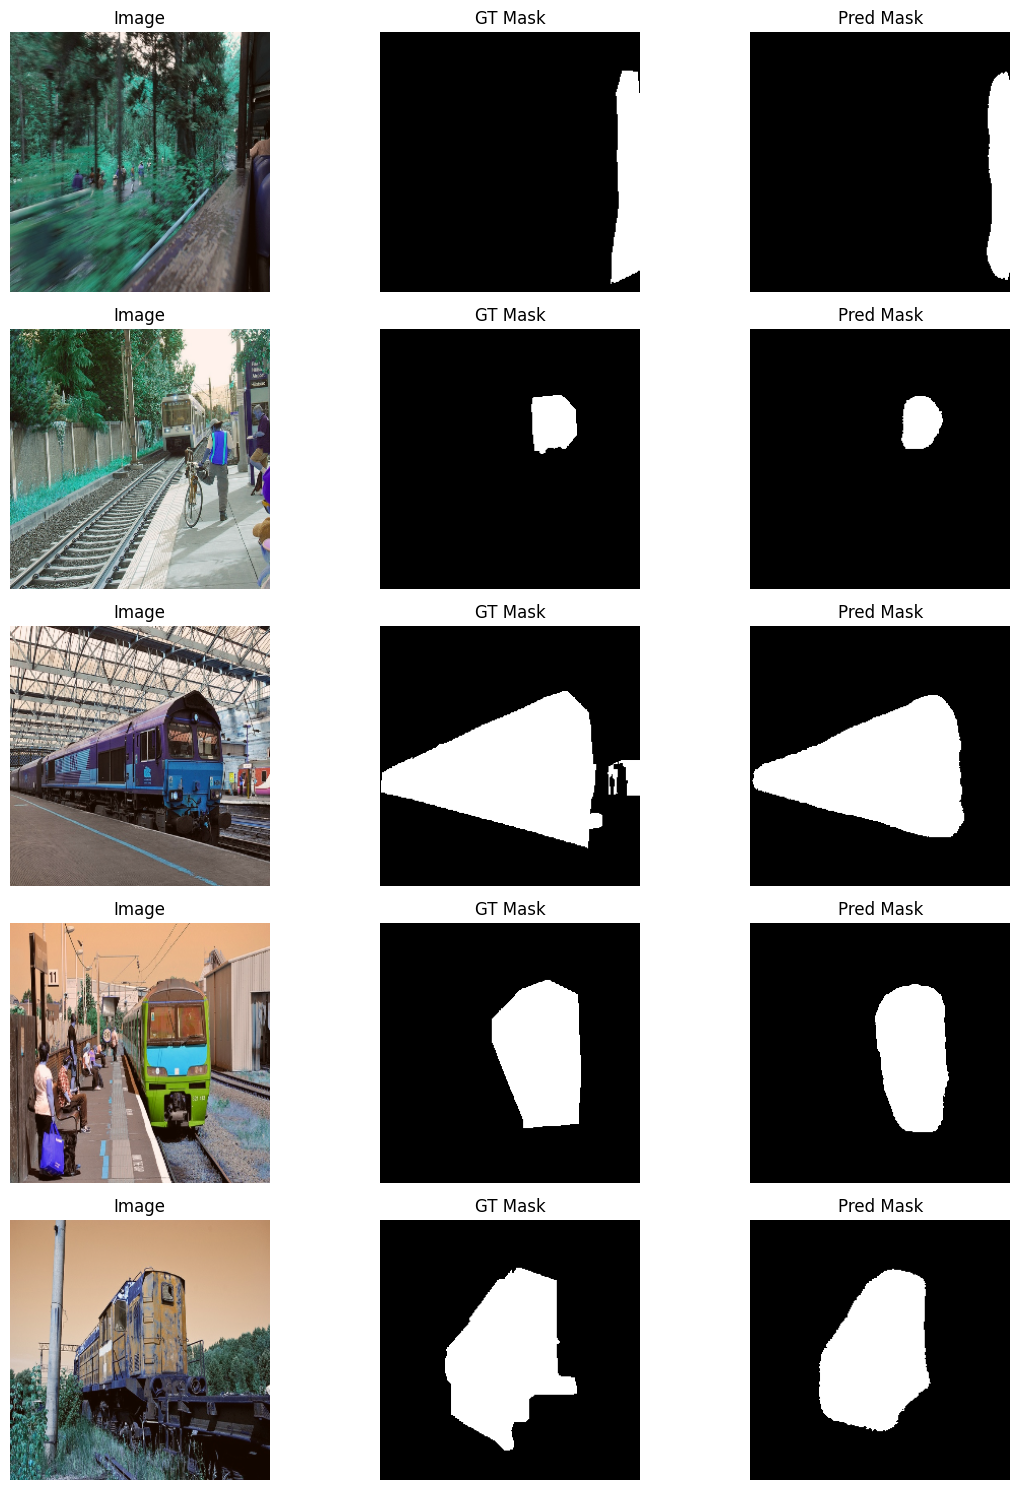

In [ ]:
# U-Net with pretrained ResNet50 encoder (ImageNet) - Week 3 (no validation)
import os, random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# --------- USER PATHS & HYPERPARAMS (EDIT AS NEEDED) ----------
IMAGE_DIR = "/content/drive/MyDrive/VisionExtract/data/coco2017/original_images"
MASK_DIR  = "/content/drive/MyDrive/VisionExtract/data/coco2017/train_masks"

IMG_H, IMG_W = 256, 256
BATCH_SIZE = 8
EPOCHS = 10          # increase later to 20-50 for real training
LIMIT = 400          # set None to use all training images; keep small for quick runs
SEED = 42

# --------- 1) Pairing images and masks (masks have _mask suffix) ----------
def get_pairs(img_dir, mask_dir):
    img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    mask_set = set(mask_files)
    pairs = []
    for img in img_files:
        stem = os.path.splitext(img)[0]            # e.g. 000000184321
        expected_mask = stem + "_mask.png"         # e.g. 000000184321_mask.png
        if expected_mask in mask_set:
            pairs.append((os.path.join(img_dir, img), os.path.join(mask_dir, expected_mask)))
    return pairs

pairs = get_pairs(IMAGE_DIR, MASK_DIR)
print("Total pairs found:", len(pairs))
if len(pairs) == 0:
    raise RuntimeError("No image-mask pairs found. Check IMAGE_DIR and MASK_DIR and mask filename suffix (_mask.png).")

# optional small-run limit
if LIMIT:
    pairs = pairs[:LIMIT]

# shuffle for training
random.seed(SEED)
random.shuffle(pairs)

# --------- 2) Simple loader (loads into memory). Use tf.data for large datasets ----------
def load_pairs_to_numpy(pairs, img_h=IMG_H, img_w=IMG_W):
    X = []
    Y = []
    for img_path, mask_path in pairs:
        # read image (cv2 returns BGR)
        img = cv2.imread(img_path)
        if img is None:
            raise RuntimeError(f"Failed to read image: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_w, img_h))
        img = img.astype(np.float32)  # keep 0..255 for preprocess_input
        img = preprocess_input(img)   # ResNet50 preprocessing (mean subtraction, etc)

        # read mask as grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise RuntimeError(f"Failed to read mask: {mask_path}")
        mask = cv2.resize(mask, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype(np.uint8)  # binary 0/1
        mask = mask[..., np.newaxis]

        X.append(img)
        Y.append(mask.astype(np.float32))

    X = np.stack(X, axis=0)
    Y = np.stack(Y, axis=0)
    return X, Y

X_train, y_train = load_pairs_to_numpy(pairs)
print("Loaded X_train:", X_train.shape, "y_train:", y_train.shape)

# --------- 3) Define Dice + BCE loss and PixelAccuracy metric ----------
def dice_coef_tf(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss_tf(y_true, y_pred):
    return 1.0 - dice_coef_tf(y_true, y_pred)

bce = tf.keras.losses.BinaryCrossentropy()

def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + dice_loss_tf(y_true, y_pred)

class PixelAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='pixel_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
        y_true_f = tf.cast(y_true, tf.float32)
        correct = tf.reduce_sum(tf.cast(tf.equal(y_true_f, y_pred_bin), tf.float32))
        total = tf.cast(tf.size(y_true_f), tf.float32)
        self.correct.assign_add(correct)
        self.total.assign_add(total)
    def result(self):
        return self.correct / (self.total + 1e-8)
    def reset_states(self):
        self.correct.assign(0.0)
        self.total.assign(0.0)

# --------- 4) Build U-Net decoder on top of pretrained ResNet50 encoder ----------
def build_unet_resnet50(input_shape=(IMG_H, IMG_W, 3), backbone_trainable=False):
    # Input expects preprocessed images (preprocess_input applied)
    inputs = layers.Input(shape=input_shape)

    # Load ResNet50 as encoder (include_top=False). We will use specific intermediate layers for skip connections.
    backbone = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    backbone.trainable = backbone_trainable  # freeze encoder initially

    # Skip connections (layer names from Keras ResNet50)
    c1 = backbone.get_layer("conv1_relu").output           # 128x128
    c2 = backbone.get_layer("conv2_block3_out").output     # 64x64
    c3 = backbone.get_layer("conv3_block4_out").output     # 32x32
    c4 = backbone.get_layer("conv4_block6_out").output     # 16x16
    c5 = backbone.get_layer("conv5_block3_out").output     # 8x8  (encoder output / bottleneck)

    # Decoder blocks (upsample + concat + convs)
    def decoder_block(x, skip, filters):
        x = layers.UpSampling2D(size=(2,2))(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        return x

    d4 = decoder_block(c5, c4, 512)   # -> 16x16
    d3 = decoder_block(d4, c3, 256)   # -> 32x32
    d2 = decoder_block(d3, c2, 128)   # -> 64x64
    d1 = decoder_block(d2, c1, 64)    # -> 128x128

    # final upsample to original resolution
    x = layers.UpSampling2D(size=(2,2))(d1)   # 256x256
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)  # binary mask

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_unet_resnet50(input_shape=(IMG_H, IMG_W, 3), backbone_trainable=False)
model.compile(optimizer=Adam(1e-4), loss=bce_dice_loss, metrics=[PixelAccuracy(), MeanIoU(num_classes=2)])
model.summary()

# --------- 5) Train (no validation) ----------
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True)

# --------- 6) Quick evaluation on the same training set (or subset) ----------
# Predict on a small subset to compute numpy metrics and visualize
n_eval = min(50, X_train.shape[0])
X_eval = X_train[:n_eval]
y_eval = y_train[:n_eval]

preds = model.predict(X_eval, batch_size=BATCH_SIZE)
pred_bins = (preds > 0.5).astype(np.uint8)

# numpy metrics
def pixel_accuracy_np(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return (y_true == y_pred).sum() / len(y_true)

def mean_iou_np(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    inter = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return 1.0 if union == 0 else inter / union

pixel_accs = [pixel_accuracy_np(y_eval[i].squeeze(), pred_bins[i].squeeze()) for i in range(len(pred_bins))]
ious = [mean_iou_np(y_eval[i].squeeze(), pred_bins[i].squeeze()) for i in range(len(pred_bins))]

print("Average Pixel Accuracy (numpy):", np.mean(pixel_accs))
print("Average Mean IoU (numpy):", np.mean(ious))

# Keras MeanIoU check
miou = MeanIoU(num_classes=2)
miou.update_state(y_eval.astype(np.uint8), pred_bins)
print("TensorFlow MeanIoU:", miou.result().numpy())

# --------- 7) Visualize a few results ----------
num_show = min(5, X_eval.shape[0])
plt.figure(figsize=(12, num_show*3))
for i in range(num_show):
    # Note: X_eval is preprocessed for ResNet (not 0..1). Convert for display:
    img_disp = X_eval[i].copy()
    # reverse preprocess_input effect roughly for display: add ImageNet mean back
    # (Not necessary; for simplicity convert to 0..1 by clipping min/max)
    img_disp = img_disp - img_disp.min()
    img_disp = img_disp / (img_disp.max()+1e-8)

    plt.subplot(num_show, 3, i*3 + 1)
    plt.imshow(img_disp)
    plt.title("Image"); plt.axis('off')

    plt.subplot(num_show, 3, i*3 + 2)
    plt.imshow(y_eval[i].squeeze(), cmap='gray')
    plt.title("GT Mask"); plt.axis('off')

    plt.subplot(num_show, 3, i*3 + 3)
    plt.imshow(pred_bins[i].squeeze(), cmap='gray')
    plt.title("Pred Mask"); plt.axis('off')
plt.tight_layout()
plt.show()


**Saved the trained model**

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/VisionExtract/unet_resnet50.keras"
model.save(MODEL_PATH)
print(f"✅ Model saved at {MODEL_PATH}")


✅ Model saved at /content/drive/MyDrive/VisionExtract/unet_resnet50.keras


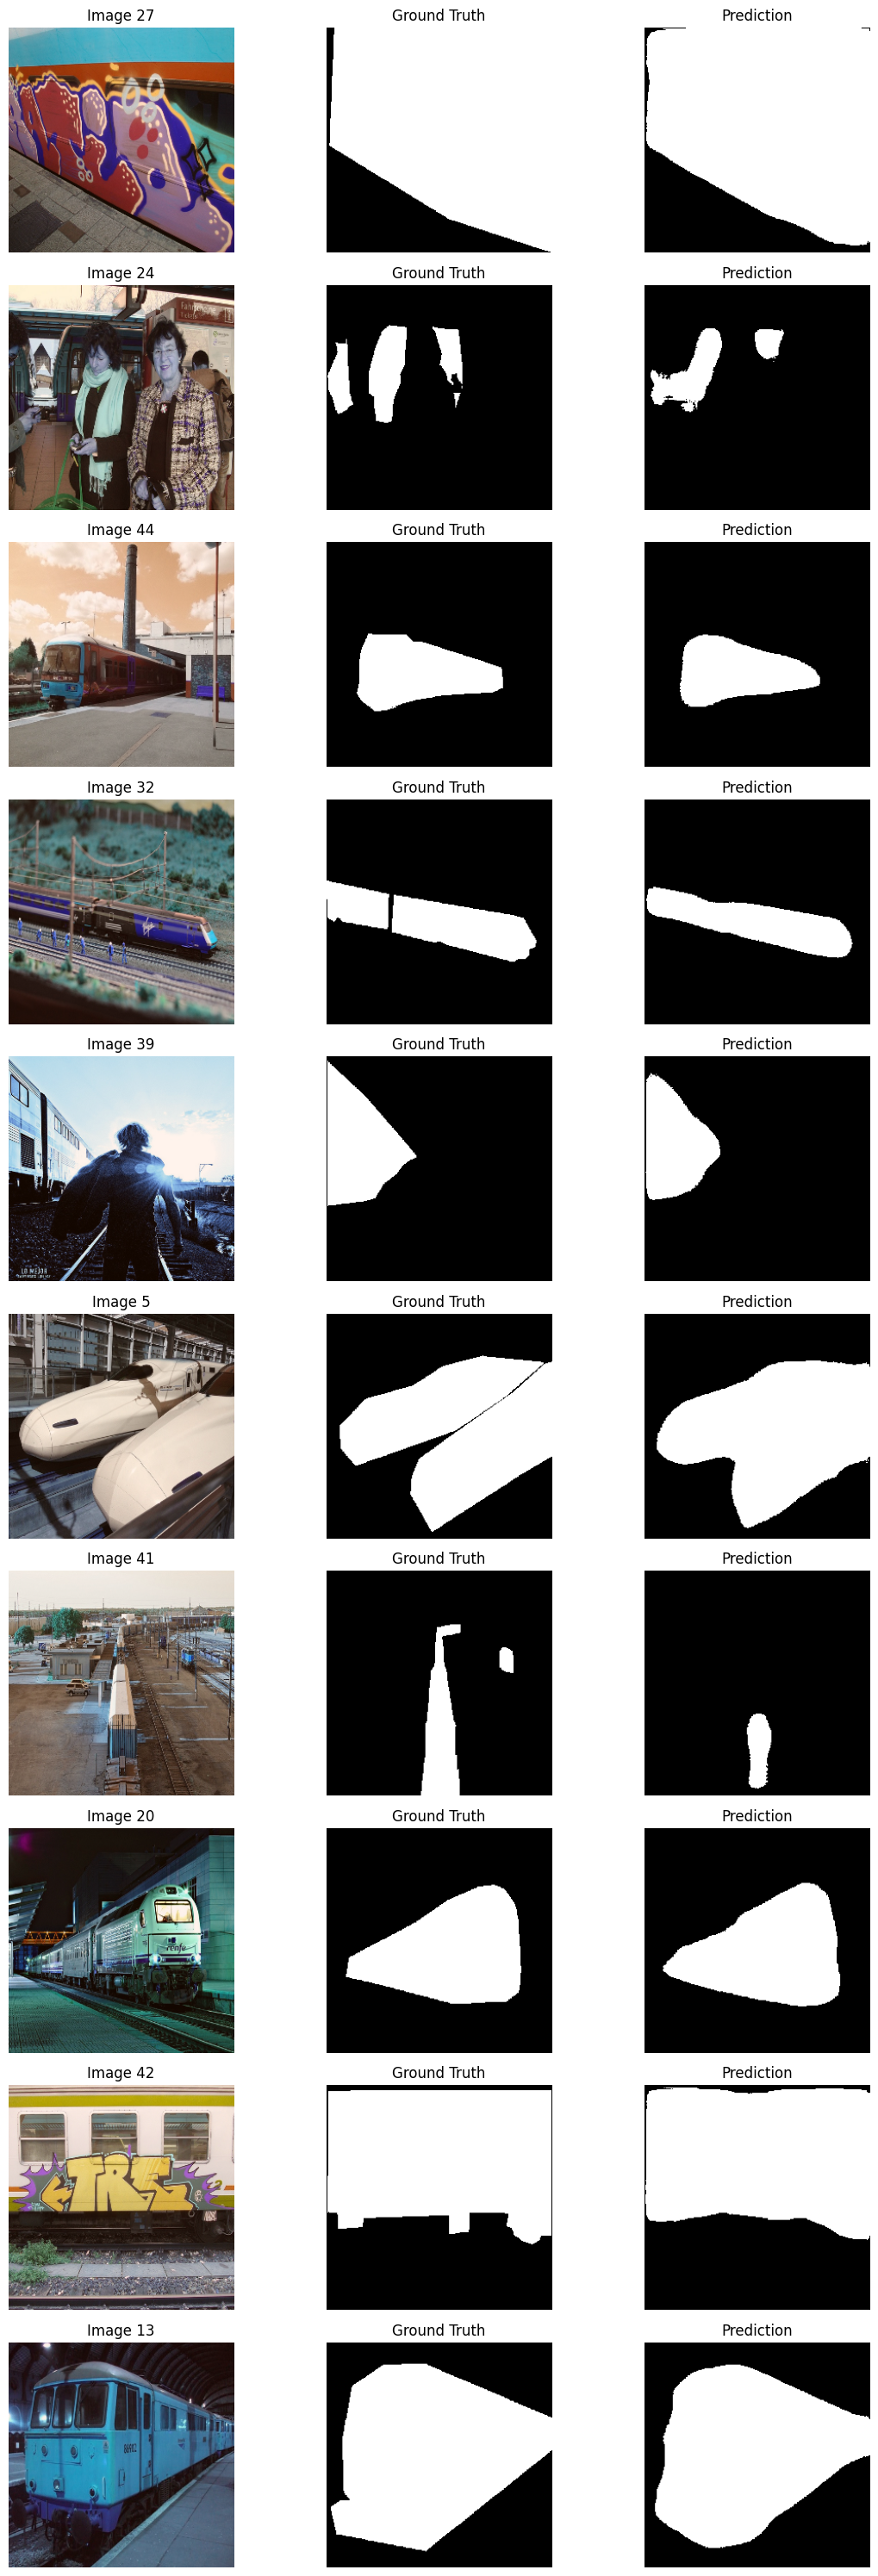

In [ ]:
# ========= Visualization Cell =========
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(X_eval, y_eval, pred_bins, num_show=10, random_sample=False):
    """
    Show input image, ground truth, and prediction side by side.

    Args:
        X_eval (numpy array): preprocessed input images
        y_eval (numpy array): ground truth masks
        pred_bins (numpy array): predicted binary masks
        num_show (int): number of images to visualize
        random_sample (bool): if True, pick random samples instead of first N
    """
    n = min(num_show, X_eval.shape[0])
    idxs = np.arange(n)
    if random_sample:
        idxs = np.random.choice(X_eval.shape[0], n, replace=False)

    plt.figure(figsize=(12, n * 3))
    for j, i in enumerate(idxs):
        # prepare image for display (since it's preprocessed for ResNet)
        img_disp = X_eval[i].copy()
        img_disp = img_disp - img_disp.min()
        img_disp = img_disp / (img_disp.max() + 1e-8)

        plt.subplot(n, 3, j*3 + 1)
        plt.imshow(img_disp)
        plt.title(f"Image {i}")
        plt.axis("off")

        plt.subplot(n, 3, j*3 + 2)
        plt.imshow(y_eval[i].squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(n, 3, j*3 + 3)
        plt.imshow(pred_bins[i].squeeze(), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---- Call the function ----
visualize_predictions(X_eval, y_eval, pred_bins, num_show=10, random_sample=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


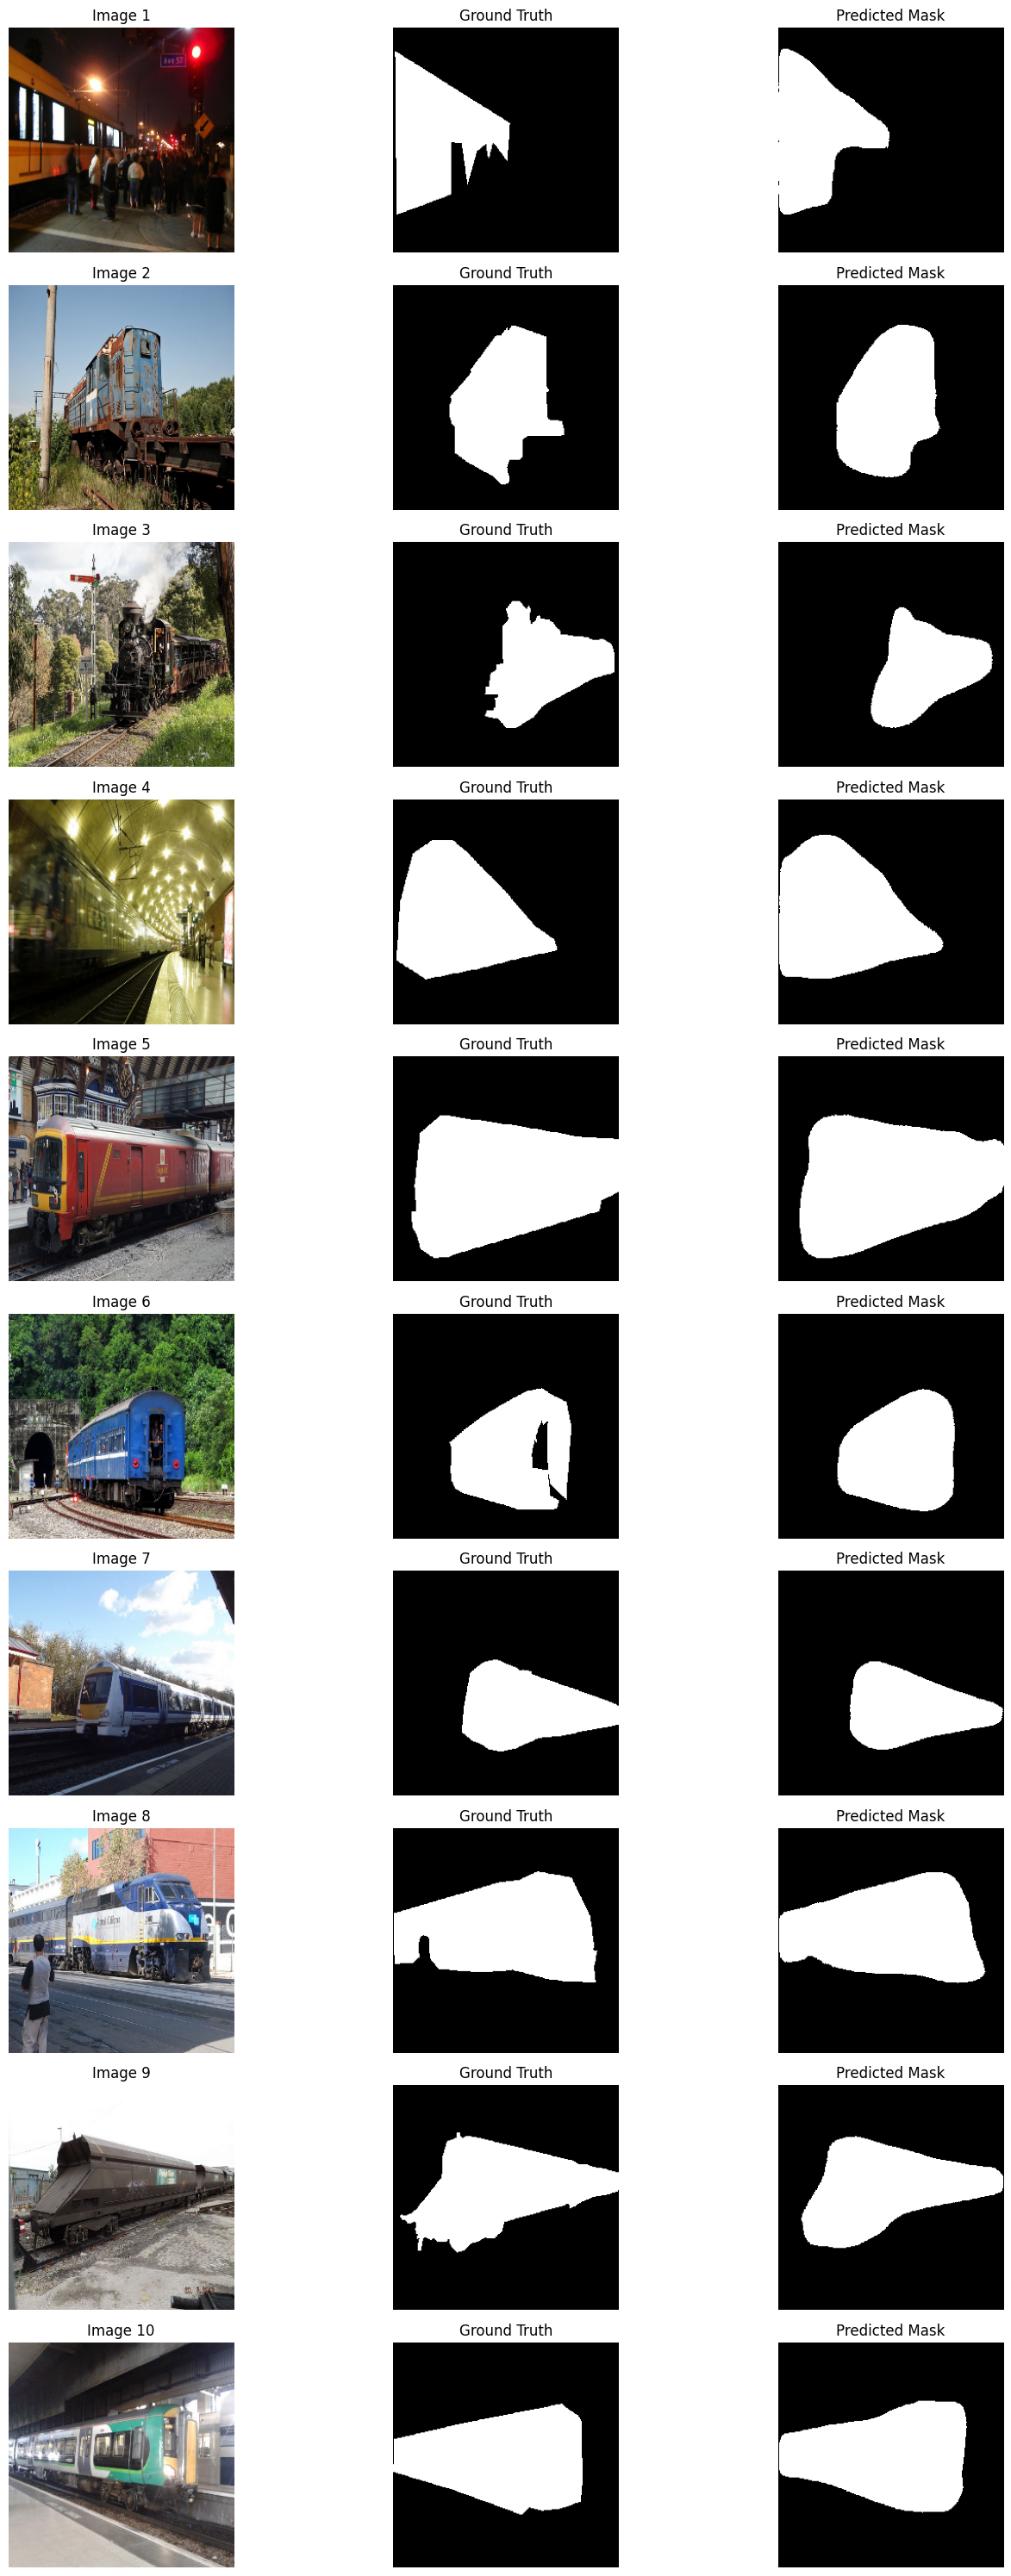

In [ ]:
# ========= Full Visualization for External Images =========
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.resnet50 import preprocess_input
import random

def visualize_external_predictions(model, images_dir, masks_dir=None, num_show=10, img_h=256, img_w=256):
    """
    Visualize predictions for external images (not training set).

    Args:
        model: trained U-Net model
        images_dir (str): folder containing test images
        masks_dir (str or None): folder containing masks (optional)
        num_show (int): number of images to visualize
        img_h, img_w: resize dimensions
    """
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(image_files) == 0:
        print("No images found in directory:", images_dir)
        return

    # Randomly select images
    selected_files = random.sample(image_files, min(num_show, len(image_files)))

    plt.figure(figsize=(15, num_show * 3))
    for idx, fname in enumerate(selected_files):
        img_path = os.path.join(images_dir, fname)
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Failed to read {fname}, skipping")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (img_w, img_h))

        # Predict mask
        img_input = preprocess_input(img_resized.astype(np.float32))
        pred = model.predict(img_input[np.newaxis, ...])
        pred_mask = (pred[0, :, :, 0] > 0.5).astype(np.uint8)

        # Load ground truth mask if available
        mask_resized = None
        if masks_dir:
            stem = os.path.splitext(fname)[0]
            for ext in [".png", ".jpg", ".jpeg"]:
                candidate = os.path.join(masks_dir, stem + "_mask" + ext)
                if os.path.exists(candidate):
                    mask = cv2.imread(candidate, cv2.IMREAD_GRAYSCALE)
                    mask_resized = cv2.resize(mask, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
                    break

        # Display images
        plt.subplot(num_show, 3, idx*3 + 1)
        img_disp = img_resized.astype(np.float32) / 255.0
        plt.imshow(img_disp)
        plt.title(f"Image {idx+1}")
        plt.axis("off")

        plt.subplot(num_show, 3, idx*3 + 2)
        if mask_resized is not None:
            plt.imshow(mask_resized, cmap="gray")
            plt.title("Ground Truth")
        else:
            plt.imshow(np.zeros((img_h, img_w)), cmap="gray")
            plt.title("No Mask")
        plt.axis("off")

        plt.subplot(num_show, 3, idx*3 + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# ========= Call the function =========
visualize_external_predictions(
    model=model,
    images_dir="/content/drive/MyDrive/VisionExtract/data/coco2017/original_images",
    masks_dir="/content/drive/MyDrive/VisionExtract/data/coco2017/train_masks",  # optional
    num_show=10,
    img_h=256,
    img_w=256
)


In [ ]:
from keras.models import load_model
from keras.optimizers import Adam

MODEL_PATH = "/content/drive/MyDrive/VisionExtract/unet_resnet50_best.keras"

# Load the best model
model = load_model(MODEL_PATH, compile=False)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
print("✅ Best model loaded successfully")


✅ Best model loaded successfully
